In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import root_pandas as rp
import pandas as pd
from tqdm import tqdm
import lmfit

from scipy.optimize import curve_fit

Welcome to JupyROOT 6.22/00


In [2]:
def func(x, a, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = a + b * np.cos(2*x) + c * np.cos(x)
    return f

In [3]:
rec_df = pd.read_csv("/Users/tylern/physics_code/build/test_mc.csv")
rec_df = rec_df[rec_df.type == "thrown"]
rec_df['cos_theta'] = np.cos(rec_df.theta)
print(rec_df.type.unique())
rec_df.head()

['thrown']


,electron_sector,w,q2,theta,phi,mm2,e_p,e_cx,e_cy,e_cz,pip_p,pip_cx,pip_cy,pip_cz,helicty,type,cos_theta
0,1,1.516318,3.459555,0.841126,4.068208,0.885597,2.217824,0.521540,0.158973,0.838286,0.805973,-0.446309,-0.596841,0.666775,-1,thrown,0.666624
1,4,1.500320,2.723559,0.543050,6.035233,0.950231,2.618047,-0.449140,-0.044632,0.892346,1.492096,0.502729,-0.132447,0.854237,1,thrown,0.856136
2,3,1.381427,2.810229,0.337767,4.122570,2.132325,2.242035,-0.084970,0.444420,0.891779,0.971727,-0.181330,-0.274681,0.944283,1,thrown,0.943497
3,4,1.299580,1.639527,0.724594,2.952941,3.511885,0.785165,-0.651910,0.115342,0.749473,1.821354,0.226930,-0.223313,0.947963,-1,thrown,0.748769
4,4,1.521985,2.529635,0.630622,6.149587,0.887706,2.707839,-0.429074,-0.022313,0.902994,1.530091,0.583107,-0.081728,0.808274,1,thrown,0.807661


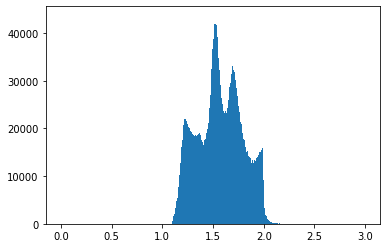

In [4]:
plt.hist(rec_df.w, bins=500, range=[0,3])
plt.show()

In [5]:
def print_and_plot_cross_sections(df):    
    #fig = plt.figure(figsize=(16,9))
    x = np.linspace(0, 2*np.pi, num=500)
    for w in tqdm(np.unique(df.w)):
        for q2 in np.sort(np.unique(df.q2)):
            for theta in np.unique(df.cos_theta):
                # print(w,q2,theta)
                d = df[(df.w == w) & (df.q2 == q2) & (df.cos_theta == theta)]
                if len(d) >= 5:
                    fig = plt.figure(figsize=(16,9))
                    #fig = plt.figure(figsize=(12,9))
                    plt.title(f"Bin\nW: {w}\nQ2: {q2}\nCos(Theta): {theta}")
                    plt.xlim(0, 2*np.pi)
                    p0 = [np.mean(d.y), 1.0, 1.0]
                    plt.errorbar(d.phi, d.y, d.yerr, fmt='o', alpha=0.5)
                    try:
                        popt, pcov = curve_fit(func, d.phi, d.y, p0=p0, maxfev=800)
                        plt.plot(x, func(x, *popt), 'g--')
                    except RuntimeError:
                        pass
                    except TypeError:
                        pass
                    
                    plt.savefig(f'W_{w}_Q2_{q2}_cosT_{theta}.png')
                    
                    
                    
                
        

In [6]:
#print_and_plot_cross_sections(df)

In [7]:
def mcmc_plot_cross_sections(df):    
    x = np.linspace(0, 2*np.pi, num=500)
    for w in tqdm(np.unique(df.w)):
        for q2 in np.sort(np.unique(df.q2)):
            for theta in np.unique(df.cos_theta):
                d = df[(df.w == w) & (df.q2 == q2) & (df.cos_theta == theta)]
                if len(d) >= 5:
                    fig = plt.figure(figsize=(16,9))
                    plt.title(f"Bin\nW: {w}\nQ2: {q2}\nCos(Theta): {theta}")
                    plt.xlim(0, 2*np.pi)
                    p0 = [np.mean(d.y), 1.0, 1.0]
                    plt.errorbar(d.phi, d.y, d.yerr, fmt='o', alpha=0.5)
                    try:
                        
                        popt, pcov = curve_fit(func, d.phi, d.y, p0=p0, maxfev=800)
                        a = popt[0]
                        b = popt[1]
                        c = popt[2]
                        plt.plot(x, func(x, *popt), 'g--', 
                                 label=f'curve_fit: a = {a:0.3f}, b = {b:0.3f}, c = {c:0.3f}')
                        
                        
#                         model = lmfit.Model(func)
#                         p = model.make_params(a=a, b=b, c=c)
                        
#                         emcee_kws = dict(steps=1000, burn=300, thin=600, is_weighted=False,
#                                      progress=False)
#                         result_mcmc = model.fit(data=d.y, params=p, x=d.phi, method='emcee', 
#                                           nan_policy='omit',fit_kws=emcee_kws)
                        
#                         a = result_mcmc.params['a'].value
#                         b = result_mcmc.params['b'].value
#                         c = result_mcmc.params['c'].value
#                         plt.plot(x, model.eval(params=result_mcmc.params, x=x), 'r--', 
#                                 label=f'mcmc: a = {a:0.3f}, b = {b:0.3f}, c = {c:0.3f}')
                        
                    except RuntimeError:
                        print("RuntimeError")
                        pass
                    except TypeError:
                        print("TypeError")
                        pass
                    plt.legend()
                    plt.savefig(f'plots/mcmc_W_{w:0.3f}_Q2_{q2:0.3f}_cosT_{theta:0.3f}.png')
                    #plt.close()
                    

In [8]:
mcmc_plot_cross_sections(rec_df)

  0%|          | 0/1217025 [01:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.hist2d(df.w, df.q2, bins=(len(np.unique(df.w)),len(np.unique(df.q2))))
plt.colorbar()
plt.show()